In [20]:
import osmnx as ox
import networkx as nx
import pandas as pd
from vincenty import vincenty
import numpy as np
import seaborn as sns

import lidar_elevation_coordinates_function as lid
import get_subnodes_from_route as gsfr

In [2]:
ROUTES = {}

In [3]:
def getBbox(l):
    min_lon = min([x[1] for x in l])
    max_lon = max([x[1] for x in l])
    min_lat = min([x[0] for x in l])
    max_lat = max([x[0] for x in l])
    
    return max_lat,min_lat,max_lon,min_lon

In [94]:
def getRoute(G, s_coord, e_coord, avoid = [], donotupdate = False):
    start_node = ox.get_nearest_node(G, s_coord)
    end_node = ox.get_nearest_node(G, e_coord)
    
    orig_lengths = []
    for item in avoid:
        orig_length = G.edges[(item[0], item[1], 0)]['length']
        orig_lengths.append(orig_length)
        G.edges[(item[0], item[1], 0)]['length'] = 50000
        
    route = nx.shortest_path(G, start_node, end_node, weight='length')
    length = nx.shortest_path_length(G, start_node, end_node, weight='length')
    
    if not donotupdate:
        for item in avoid:
            orig_length = orig_lengths.pop()
            G.edges[(item[0], item[1], 0)]['length'] = orig_length
    
    return route, length

In [5]:
def getAllLocations(G,route):
    loc = []
    for node in route:
        loc.append((G.nodes[node]['y'],G.nodes[node]['x']))
    return loc

In [93]:
def getRouteAndAddToCollection(G, coord1, coord2, name, df, avoid = [], donotupdate=False):
    r, length = getRoute(G, coord1, coord2, avoid = avoid, donotupdate=donotupdate)
    l = getAllLocations(G, r)
    
    max_lat,min_lat,max_lon,min_lon = getBbox(l)
    
    p_50,p_100,p_250 = getNumAccPoi(df,l,min_lat,min_lon,max_lat,max_lon)
    
    e_down, e_up, distances, elevation, distrib = computeTotalElevation(l)

    ROUTES[name] = {'length':length,'locations':l,'route':r,'p50':p_50,'p100':p_100,'p250':p_250,'downhill':e_down,'uphill':e_up,'distances':distances, 'slope_distribution':distrib, 'elevation':elevation}

In [7]:
def computeTotalElevation(l):
    elev_down = 0
    elev_up = 0
    old_elev = -1
    distrib = []
    old_coord = -1
    
    distances = []
    
    elevation = []
    for item in l:
        _ = lid.get_elevation(item, '/shared/lidar/study_area.tif')
        diff = 0
        if _ is not None:
            if old_elev != -1:
                diff = (_[0]['elevation'] - old_elev)
                if diff < 0:
                    elev_down += diff
                else:
                    elev_up += diff
            old_elev = _[0]['elevation']
            
            if old_coord != -1:
                dist = vincenty(old_coord,item) * 1000
                distrib.append(diff/dist)
                distances.append(dist)
                elevation.append(_[0]['elevation'])

            
            old_coord = item
        

    return elev_down,elev_up,distances,elevation,distrib

In [8]:
def getNumAccPoi(df,l,lat_min,lon_min,lat_max,lon_max):
    _ = df[(df['lon']>lon_min-0.1)&(df['lon']<lon_max+0.1)&(df['lat']>lat_min-0.1)&(df['lat']<lat_max+0.1)]
    num_acc_pois_50  = 0
    num_acc_pois_100 = 0
    num_acc_pois_250 = 0
    for _row,_col in _.iterrows():
        _col['p50'] = False
        _col['p100'] = False
        _col['p250'] = False
        for _l in l:
            # Compute distance
            d = vincenty((_l[0],_l[1]),(_col['lat'],_col['lon'])) * 1000.0
            if d <= 50 and not _col['p50']:
                _col['p50'] = True
                num_acc_pois_50 += 1
            if d <= 100 and not _col['p100']:
                _col['p100'] = True
                num_acc_pois_100 += 1
            if d <= 250 and not _col['p250']:
                _col['p250'] = True
                num_acc_pois_250 += 1
    return num_acc_pois_50,num_acc_pois_100,num_acc_pois_250

In [9]:
G_walk = ox.graph_from_address(address="London", dist=5000, network_type="walk")
G_drive = ox.graph_from_address(address="London", dist=5000, network_type="drive")

In [10]:
#G = ox.graph.graph_from_bbox(51.58, 51.45, 0.08, -0.3, network_type='walk', simplify=True, retain_all=False, truncate_by_edge=False, clean_periphery=True, custom_filter=None)

#ox.plot_graph(G)

In [125]:
df = pd.read_pickle('/shared/combined_accessible_pois.pkl')

# Define routes here
coord1          = (51.50815,-0.076303) # Tower of London
coord2          = (51.50457,-0.108711) # London Waterloo East Tube Station
coord3          = (51.50106,-0.124613) # Big Ben
coord4          = (51.48402,-0.606044) # Windsor castle

coord_starting  = (51.556974,-0.112079) # Holloway
coord_regent    = (51.530760,-0.156740) # Regent's Park

coord_tmp       = (51.519599051500094, -0.15820421319589217)
coord_tmp_end   = (51.49887208008789, -0.1048175303045337)

coord_leicester = (51.510310,-0.130050)
coord_city      = (51.513167,-0.089958)

coord_trafalgar = (51.5008001,-0.128044)

coord_fulham    = (51.483518,-0.193411) 

coord_marble_arch=(51.51552196067298, -0.1581658851293169)

#getRouteAndAddToCollection(G_drive,coord1,coord2,'short1-drive',df)
#getRouteAndAddToCollection(G_drive,coord1,coord3,'short2-drive',df)
#getRouteAndAddToCollection(G_drive,coord2,coord3,'short3-drive',df)

#getRouteAndAddToCollection(G_walk,coord1,coord2,'short1',df)
#getRouteAndAddToCollection(G_walk,coord1,coord3,'short2',df)
#getRouteAndAddToCollection(G_walk,coord2,coord3,'short3',df)

#getRouteAndAddToCollection(G_walk,coord1,coord2,'short1-avoid',df,avoid = [(ROUTES['short1']['route'][4],ROUTES['short1']['route'][5]),(ROUTES['short1']['route'][7],ROUTES['short1']['route'][8]),(ROUTES['short1']['route'][18],ROUTES['short1']['route'][19])])

#getRouteAndAddToCollection(G_walk,coord_tmp,coord_tmp_end,'longer-route',df)

##############
## PERSONAS ##
##############

#getRouteAndAddToCollection(G_walk,coord2,coord3,'personas-short',df)
getRouteAndAddToCollection(G_walk,coord_leicester,coord_city,'personas-long',df)


/home/luca.bedogni/dsg/p3venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

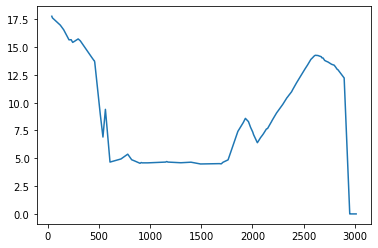

In [126]:
dd = np.cumsum(ROUTES['personas-long']['distances'])
sns.lineplot(dd,ROUTES['personas-long']['elevation'])

/home/luca.bedogni/dsg/p3venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

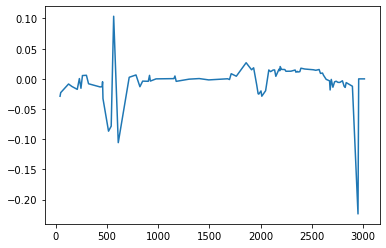

In [127]:
sns.lineplot(dd,ROUTES['personas-long']['slope_distribution'])


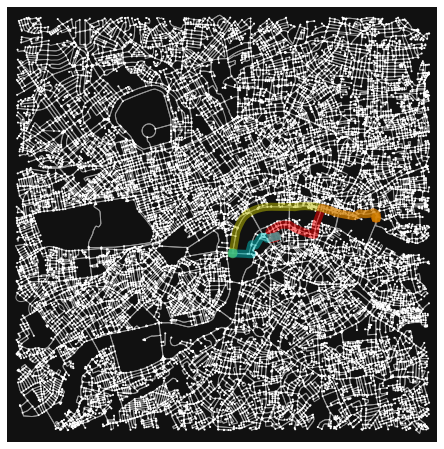

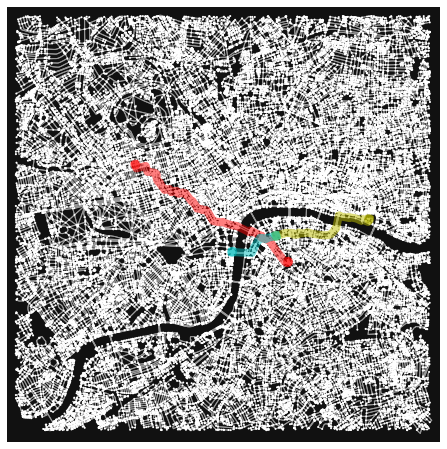

In [14]:
routes = [ROUTES['short1-drive']['route'], ROUTES['short2-drive']['route'], ROUTES['short3-drive']['route']]
rc = ['r', 'y', 'c']
fig, ax = ox.plot_graph_routes(G_drive, routes, route_colors=rc, route_linewidth=8, node_size=4)


routes = [ROUTES['longer-route']['route'], ROUTES['short1']['route'], ROUTES['short3']['route']]
fig, ax = ox.plot_graph_routes(G_walk, routes, route_colors=rc, route_linewidth=8, node_size=4)

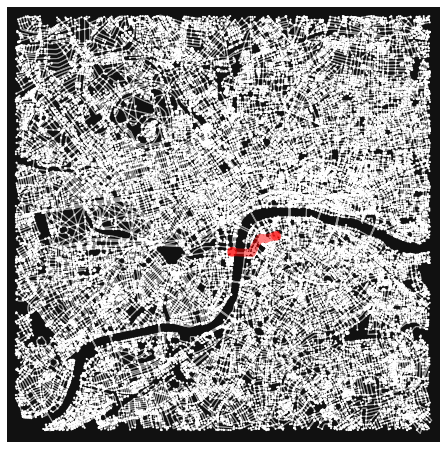

In [45]:
bbox = getBbox(ROUTES['personas-short']['locations'])
#fig, ax = ox.plot_graph_route(G_walk, ROUTES['holloway-regent']['route'], route_linewidth=8, node_size=4, bbox=bbox)
fig, ax = ox.plot_graph_route(G_walk, ROUTES['personas-short']['route'], route_linewidth=8, node_size=4)

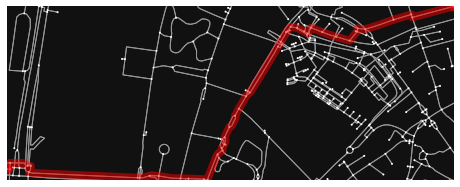

In [46]:
bbox = getBbox(ROUTES['personas-short']['locations'])
fig, ax = ox.plot_graph_route(G_walk, ROUTES['personas-short']['route'], route_linewidth=8, node_size=4, bbox=bbox)

In [34]:
import random
import get_subnodes_from_route_v2 as gsfr
out = gsfr.getSubnodes(G_walk, ROUTES['longer-route']['route'])
_out = random.sample(out,2)
_out

nodes_to_avoid = [x['node_osmids'] for x in _out]
nodes_to_avoid

getRouteAndAddToCollection(G_walk,coord_tmp,coord_tmp_end,'longer-route',df,avoid=nodes_to_avoid)

(2525878187, 2663242360)
(1754991191, 33674195)
(2525878187, 2663242360) 55.845
(1754991191, 33674195) 21.848


In [128]:
def optimizeRoute(route):
    
    nodes_too_steep = []
    for x in route['slope_distribution']:
        if x > 0.083 or x < -0.083:
            nodes_too_steep.append(x)
    
    # Get IDS
    idx = [route['slope_distribution'].index(x) for x in nodes_too_steep]
    try:
        idx.remove(0)
    except:
        pass
    try:
        idx.remove(len(route['route']))
    except:
        pass
    #idx.pop(len(route['route']))
    ids_to_avoid = [(route['route'][x-1],route['route'][x],0) for x in idx]
   #ids_to_avoid = [(route['route'][x],route['route'][x+1]) for x in idx]
    
    print(ids_to_avoid)
    return ids_to_avoid

In [140]:
_G_walk = G_walk.copy()
for i in range(5):
    print('***************************')
    print(f'Optimizing: iteration {i}')
    avoid_ids = []
    if i > 0:
        avoid_ids = optimizeRoute(ROUTES[f'personas-long-{i-1}'])
    else:
        avoid_ids = optimizeRoute(ROUTES['personas-long'])
        
    if len(avoid_ids) == 0:
        break
    
    for ai in avoid_ids:
        print(_G_walk.edges[ai])
    getRouteAndAddToCollection(_G_walk,coord2,coord3,f'personas-long-{i}',df,avoid=avoid_ids,donotupdate=True)



***************************
Optimizing: iteration 0
[(1947257511, 2564873547, 0), (25476014, 25476037, 0), (25476037, 25476039, 0), (1401926435, 25161348, 0)]
{'osmid': 4254114, 'highway': 'footway', 'oneway': False, 'length': 3.975}
{'osmid': 4254113, 'name': 'York Buildings', 'highway': 'residential', 'maxspeed': '20 mph', 'oneway': False, 'length': 26.133000000000003, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f83c0740c10>}
{'osmid': [4254112, 100619431], 'oneway': False, 'name': 'Lower Robert Street', 'highway': 'service', 'length': 25.459, 'tunnel': 'yes', 'geometry': <shapely.geometry.linestring.LineString object at 0x7f83c0754580>}
{'osmid': 230191864, 'name': 'Queen Victoria Street', 'highway': 'tertiary', 'maxspeed': '20 mph', 'oneway': False, 'length': 60.432, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f83b18e1d60>}
***************************
Optimizing: iteration 1
[(2969191026, 2623916648, 0), (345843414, 4084403506, 0)]
{'osmid'

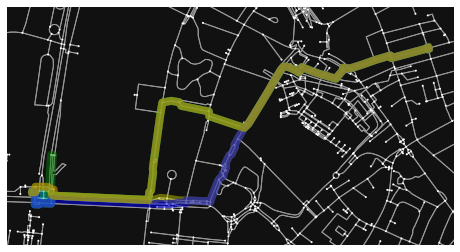

In [145]:
bbox = getBbox(ROUTES['personas-long-1']['locations'])

routes = [ROUTES['personas-long']['route'], 
          ROUTES['personas-long-0']['route'], 
          ROUTES['personas-long-1']['route'],
         ROUTES['personas-long-2']['route'],
         ROUTES['personas-long-3']['route'],
         ROUTES['personas-long-4']['route']]
rc = ['r', 'y', 'c' ,'b','g','orange']

bbox = [bbox[0]+0.001,bbox[1]-0.001,bbox[2]+0.001,bbox[3]-0.001]

fig, ax = ox.plot_graph_routes(G_walk, routes, route_colors=rc, route_linewidth=8, node_size=4, bbox=bbox)


#routes = [ROUTES['longer-route']['route'], ROUTES['short1']['route'], ROUTES['short3']['route']]
#fig, ax = ox.plot_graph_routes(G_walk, routes, route_colors=rc, route_linewidth=8, node_size=4)

/home/luca.bedogni/dsg/p3venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/luca.bedogni/dsg/p3venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/luca.bedogni/dsg/p3venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpreta

<AxesSubplot:>

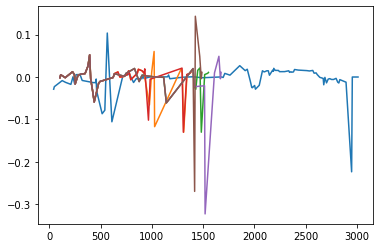

In [144]:
dd = np.cumsum(ROUTES['personas-long']['distances'])
sns.lineplot(dd,ROUTES['personas-long']['slope_distribution'])

dd = np.cumsum(ROUTES['personas-long-0']['distances'])
sns.lineplot(dd,ROUTES['personas-long-0']['slope_distribution'])

dd = np.cumsum(ROUTES['personas-long-1']['distances'])
sns.lineplot(dd,ROUTES['personas-long-1']['slope_distribution'])

dd = np.cumsum(ROUTES['personas-long-2']['distances'])
sns.lineplot(dd,ROUTES['personas-long-2']['slope_distribution'])

dd = np.cumsum(ROUTES['personas-long-3']['distances'])
sns.lineplot(dd,ROUTES['personas-long-3']['slope_distribution'])

dd = np.cumsum(ROUTES['personas-long-4']['distances'])
sns.lineplot(dd,ROUTES['personas-long-4']['slope_distribution'])


In [16]:
l = getAllLocations(G_walk,ROUTES['longer-route']['route'])
with open('/shared/tmp_coord_longer.csv','w') as f:
    for i in l:
        f.write(str(i) + ';')